# Import Libaries 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import datetime
import numpy as np
from deploy_config import*  #Import Paths and Model Config file
from loss_funnction_And_matrics import*  #Import Loss functions
from Resnet_3D import Resnet3D #import the model
import pandas as pd
from tensorflow.keras.optimizers import Adam
import cv2

# Configure Model 

In [2]:
###---Load The model----###
INPUT_PATCH_SIZE=(128,128,128,1)
inputs = tf.keras.Input(shape=INPUT_PATCH_SIZE, name='CT')
Model_3D=Resnet3D(inputs,num_classes=NUMBER_OF_CLASSES) # Load Model
Model_3D.load_weights('mymodel_21.30_30.h5') #Load Weights
print('Loading The Model from this path--{}'.format(MODEL_PATH))
Model_3D.summary()
###---lAYER-Name--to-visualize--###
LAYER_NAME='conv3d_18'
# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([Model_3D.inputs], [Model_3D.get_layer(LAYER_NAME).output, Model_3D.output])
grad_model.summary()

Loading The Model from this path--/Local/new_3d_classification_test/Liver_Deploy/mymodel_6.92_28.h5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CT (InputLayer)                 [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 432         CT[0][0]                         
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 128 64          conv3d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Relu6 (TensorFlowOp [(None, 128, 128, 12 0           batch_normalization[0][0]   

# Function to Resize the 3D volume 

In [3]:
def resize_image_with_crop_or_pad(image, img_size=(64, 64, 64), **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.
    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad
    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer], to_padding, **kwargs)

# Loading volume and compute the gradients 

In [4]:
##----Load---Image
import SimpleITK as sitk
img_path='XXX-IMAG.nii.gz'
img_sitk = sitk.ReadImage(img_path, sitk.sitkFloat32)
image= sitk.GetArrayFromImage(img_sitk)
resized_img=resize_image_with_crop_or_pad(image=image,img_size=(128,128,128),mode='symmetric')
#resized_img=image
resized_img.shape
io_img=tf.expand_dims(resized_img, axis=-1)
print(io_img.shape)
io_img=tf.expand_dims(io_img, axis=0)
print(io_img.shape)
###----index of the class
CLASS_INDEX=2

###--Compute GRADIENT
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(io_img)
    loss = predictions[:, CLASS_INDEX]

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

C:\Users\tusha\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(128, 128, 128, 1)
(1, 128, 128, 128, 1)


In [5]:
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1,2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]

Text(0.5, 1.0, 'Overlay')

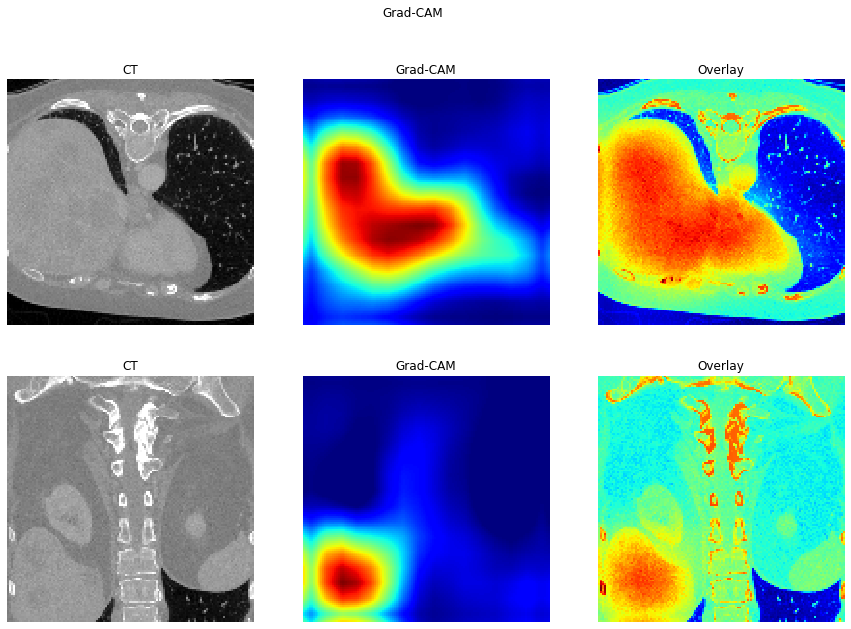

In [8]:
from skimage.transform import resize
from matplotlib import pyplot as plt
capi=resize(cam,(128,128,128))
#print(capi.shape)
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())
f, axarr = plt.subplots(2,3,figsize=(15,10));
f.suptitle('Grad-CAM')
slice_count=127
slice_count2=30
    
axial_ct_img=np.squeeze(resized_img[slice_count, :,:])
axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])

coronal_ct_img=np.squeeze(resized_img[:,slice_count2,:])
coronal_grad_cmap_img=np.squeeze(heatmap[:,slice_count2,:]) 

img_plot = axarr[0,0].imshow(axial_ct_img, cmap='gray');
axarr[0,0].axis('off')
axarr[0,0].set_title('CT')
    
img_plot = axarr[0,1].imshow(axial_grad_cmap_img, cmap='jet');
axarr[0,1].axis('off')
axarr[0,1].set_title('Grad-CAM')
    
axial_overlay=cv2.addWeighted(axial_ct_img,0.3,axial_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[0,2].imshow(axial_overlay,cmap='jet');
axarr[0,2].axis('off')
axarr[0,2].set_title('Overlay')


img_plot = axarr[1,0].imshow(coronal_ct_img, cmap='gray');
axarr[1,0].axis('off')
axarr[1,0].set_title('CT')
    
img_plot = axarr[1,1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1,1].axis('off')
axarr[1,1].set_title('Grad-CAM')
    
Coronal_overlay=cv2.addWeighted(coronal_ct_img,0.3,coronal_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[1,2].imshow(Coronal_overlay,cmap='jet');
axarr[1,2].axis('off')
axarr[1,2].set_title('Overlay')